In [23]:
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import structured_light_tomography.models as models
import structured_light_tomography.training as training
import structured_light_tomography.dataset_generation as dg
import structured_light_tomography.photocount_treatment as pt
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plts
from os.path import join
import torchvision
import torch.nn.functional as F
import h5py
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from structured_light_tomography.training import fidelity

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

def format_data(x):
    mean = [x[:, n, :, :].mean() for n in range(x.shape[1])]
    std = [x[:, n, :, :].std() for n in range(x.shape[1])]

    X = v2.Compose([
            torch.from_numpy,
            v2.Normalize(mean=mean, std=std),
            v2.Resize((64, 64)),
        ])(x).to(device)
    return X

Using cuda device


In [17]:
orders = range(1,5)
photocounts = [2**i for i in range(6, 12)]

In [11]:
for order in orders:
    for n in photocounts:
        with h5py.File('TrainingData/photocount.h5', 'r') as f:
            x = f[f'x_order{order}_{n}'][:]
            y = f[f'y_order{order}_{n}'][:]
            
        X = format_data(x)
        Y = torch.from_numpy(y).to(device)

        dset = TensorDataset(X, Y)

        train_size = int(0.85 * len(dset))
        test_size = len(dset) - train_size

        train_dataset, test_dataset = random_split(dset, [train_size, test_size])
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=256)

        L = x.shape[2]
        loss_fn = training.fidelity_loss
        n_channels = 2
        n_classes = 2*(order+1)

        model = models.ConvNet(L,L,n_channels, n_classes,[24,40,35],5,nn.ELU,[120,80,40]).to(device)

        optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

        save_path = f"runs/Pure/Order{order}/{n} Photocounts"

        writer = SummaryWriter(save_path)
        early_stopping = training.EarlyStopping(patience=30,save_path=save_path)
        for t in range(200):
            epoch = t+1
            print(f"-------------------------------\nEpoch {epoch}")
            training.train(model, train_loader, loss_fn, optimizer, device)
            val_loss = training.test(model, test_loader, loss_fn, device, epoch, writer, verbose=True)
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
        print("Done!")
        writer.close()

-------------------------------
Epoch 1
Training loss: 0.19974626
-------------------------------
Epoch 2
Training loss: 0.19510691
-------------------------------
Epoch 3
Training loss: 0.17267289
-------------------------------
Epoch 4
Training loss: 0.16789547
-------------------------------
Epoch 5
Training loss: 0.16553978
-------------------------------
Epoch 6
Training loss: 0.16335832
-------------------------------
Epoch 7
Training loss: 0.16137547
-------------------------------
Epoch 8
Training loss: 0.16063444
-------------------------------
Epoch 9
Training loss: 0.15925664
-------------------------------
Epoch 10
Training loss: 0.15952635
-------------------------------
Epoch 11
Training loss: 0.15870310
-------------------------------
Epoch 12
Training loss: 0.15898612
-------------------------------
Epoch 13
Training loss: 0.15903803
-------------------------------
Epoch 14
Training loss: 0.15838780
-------------------------------
Epoch 15
Training loss: 0.15940388
----

In [32]:
orders = range(1,5)
photocounts = [2**i for i in range(6, 12)]

fids = torch.empty(4,len(photocounts))

for order in orders:
    with h5py.File('ExperimentalData/Photocount/datasets.h5', 'r') as f:
        histories = f[f'histories_order{order}'][:]
        y_exp = dg.real_representation(f[f'coefficients_order{order}'][:])
    Y_exp = torch.from_numpy(y_exp).to(device)
    
    for (k,n) in enumerate(photocounts):
        x_exp = np.float32(np.array([pt.array_representation(history[:n],(2,64,64)) for history in histories]))
        X_exp = format_data(x_exp)
        model = torch.load(f"runs/Pure/Order{order}/{n} Photocounts/checkpoint.pt")
        #model.eval()

        with torch.no_grad():
            fids[order-1,k] = fidelity(model(X_exp),Y_exp).mean()

fids = fids.numpy()

/home/marcsgil/Desktop/structured_light_tomography/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


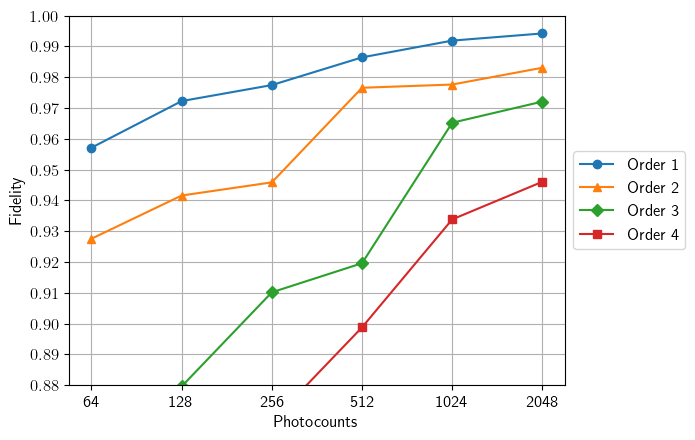

In [84]:
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import numpy as np

# Enable LaTeX fonts
rc('text', usetex=True)

# Increase font size
rcParams['font.size'] = 12

# Apply log2 transformation to photocounts
log_photocounts = np.log2(photocounts)

# Set the x and y labels
plt.xlabel("Photocounts")
plt.ylabel("Fidelity")

# Create a list of markers
markers = ['o', '^', 'D', 's']

# Assuming fids is your matrix
for i, line in enumerate(fids, start=1):
    # Use the order index to select a marker from the list
    plt.plot(log_photocounts, line, label=f"Order {i}", marker=markers[i-1])

# Set the xticks to be the original photocounts values
plt.xticks(log_photocounts, photocounts)

# Set the y-axis limits
plt.ylim([0.9, 1])

# Set the y-axis ticks
plt.yticks(np.arange(0.88, 1.01, 0.01))

# Display the labels outside the plotting area
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

# Display both major and minor grids
plt.grid(which='both')

# Set the minor grid lines to a dotted style and decrease their alpha value
plt.grid(which='minor', linestyle=':', alpha=0.5)

# Save the plot as a PDF file with all elements included
plt.savefig("plots/fidelities_ml.png", bbox_inches='tight')

plt.show()

<Figure size 640x480 with 0 Axes>